In [60]:
import numpy as np
import pandas as pd

import itertools
from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
np.random.seed(42)

### Функции

In [62]:
# разбиение выборки на тренировочную и валидационную
def train_test_split(x, y, test_size=0.3):
    indexes = range(x.shape[0])
    train_len = int(x.shape[0]*(1-test_size))

    train_indexes = np.random.choice(indexes, size=train_len, replace=False)
    test_indexes = [i for i in indexes if i not in train_indexes]

    return x[train_indexes], y[train_indexes], x[test_indexes], y[test_indexes]

In [63]:
# вычисляет ROC
def roc(y, probas):
    # combined (real value, score)
    data = sorted(np.array([(y[i], probas[i]) for i in range(len(y))]), reverse=True, key=lambda e: e[1])
    
    tt = float(len(y[y == 1]))
    tf = float(len(y) - tt)
    ft, ff = 0.0, 0.0
    
    tprs, fprs  = [0.0], [0.0]
    
    for d in data:
        if d[0] == 1:
            ft += 1
        else:
            ff += 1
            
        tprs.append(ft / tt)
        fprs.append(ff / tf)
        
    return fprs, tprs

In [64]:
# вычисляем ROC_AUC
def roc_auc(y, y_proba):
    fprs, tprs = roc(y, y_proba)
    
    return np.trapz(tprs, x = fprs, dx=0.1)

In [65]:
# стандартизация - не дала прироста
def normalize(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = (X[i][j] - means[j])/stds[j]
            
    return X

In [66]:
# нормализация - не дала прироста
def minimax(X):
    minis = np.min(X, axis=0)
    maxis = np.std(X, axis=0)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = (X[i][j] - minis[j])/(maxis[j] - minis[j])
            
    return X

In [67]:
# Евклидова метрика
def e_metrics(x1, x2):
    distance = np.sum([(x1[i] - x2[i])**2 for i in range(len(x1))])

    return np.sqrt(distance)

In [95]:
# KNN
def knn(x_train, y_train, x_test, k, wq=None):
    answers, proba = [], []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            distance = e_metrics(x, x_train[i])   
                
            w = 0
            if wq:
                w = wq**i
            test_distances.append((distance + w, y_train[i]))
        
        classes = {class_item: 0 for class_item in set(y_train)}
        
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        proba.append((classes.get(1) or 0)/k)
        answers.append(sorted(classes, key=classes.get)[-1])
    return proba, answers

In [69]:
# кросс-валидация
def cv(x_train, y_train, x_test, y_test, model, params, score_func):
    keys = params.keys()
    vals = params.values()
    
    perms = list(itertools.product(*vals))
    settings = [dict(zip(keys, p)) for p in perms]
    print('Total: ', len(settings))
    
    scores = []
    for s in settings:
        print('Processing: ', s)
        proba, pred = model(x_train, y_train, x_test, **s)
        
        score = score_func(y_test, proba)
        print('Score: ', score)
        scores.append((s, score))
        
    print('Done')
    return max(scores, key=itemgetter(1))[0]

### Загрузка и анализ данных

In [70]:
train_df = pd.read_csv('classification_train.csv')

In [71]:
train_df.shape

(10000, 13)

In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
choose                 10000 non-null int64
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [73]:
train_df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


In [74]:
train_df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


physics                0.195183
mean_exam_points       0.109409
chemistry              0.091878
biology                0.071310
qualification          0.042160
years_of_experience    0.029010
english                0.022227
age                    0.017165
Id                     0.012043
geography              0.006366
history               -0.004700
lesson_price          -0.134013
Name: choose, dtype: float64

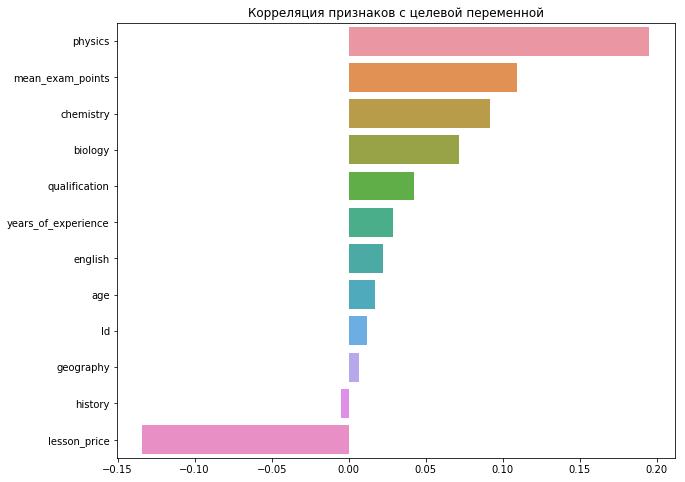

In [75]:
target_corr = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)

plt.title('Корреляция признаков с целевой переменной')
target_corr

### Подготовка данных

In [79]:
train_target = train_df['choose']
train_data = train_df.drop(['Id', 'choose'], axis=1)

In [89]:
x_train, y_train, x_test, y_test = train_test_split(train_data.values, train_target.values, test_size=0.3)

### Подбор парметров

In [106]:
 p = {'wq': [None], 'k': [15, 16]}

In [107]:
%%time
# пока отключим, здесь было много прогонов с целью найти лучшие данные
#cv(x_train, y_train, x_test, y_test, knn, p, roc_auc)

Total:  2
Processing:  {'wq': None, 'k': 15}
Score:  0.769132783151167
Processing:  {'wq': None, 'k': 16}
Score:  0.7685059664451206
Done
CPU times: user 18min 8s, sys: 6.21 s, total: 18min 14s
Wall time: 18min 59s


{'wq': None, 'k': 15}

### Загрузка тестовых данных и сохранение предсказаний

In [109]:
test_df = pd.read_csv('classification_test.csv')

In [110]:
test_df.shape

(10000, 12)

In [111]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [112]:
test_df = test_df.drop(['Id'], axis=1)

In [113]:
test_df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


In [114]:
proba, predictions = knn(train_data.values, train_target.values, test_df.values, k=15)

In [116]:
res = pd.DataFrame(data=np.array(predictions).astype('int64'), columns=['choose'])
res.index += 10000
res.to_csv('MLevanov_classification_predictions.csv', index_label='Id')